<a href="https://colab.research.google.com/github/ronitd2002/QROSS-GCN-project/blob/main/trial-notebooks/QROSS_Naive-Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# basic libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

### Importing and normalizing the data

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# upload training data
from google.colab import files

uploaded_1 = files.upload()

In [ ]:
import os

graphs = {}
index = 0

for filename, file_data in uploaded_1.items():
    file_content = file_data.decode('utf-8')

    start_collecting = False
    coordinates = []

    for line in file_content.splitlines():
        if "NODE_COORD_SECTION" in line:
            start_collecting = True
            continue

        if "EOF" in line or line.strip() == '':
            break

        if start_collecting:
            parts = line.split()
            if len(parts) >= 3:
                # Append [x, y] coordinates (ignore the first column)
                coordinates.append([float(parts[1]), float(parts[2])])

    graphs[index] = coordinates
    index += 1

In [ ]:
for graph in graphs:
    print(f"Instance: {graph}\nCoordinates: {graphs[graph]}\n")
    break

In [ ]:
print(f"Euclidean coordinates of the 35th graph instance are:")
graphs[35]

In [ ]:
print(f"We have {len(graphs)} graphs each having {len(graphs[0])} [x,y] coordinate points")

In [ ]:
# upload training data
from google.colab import files

uploaded_2 = files.upload()

In [ ]:
import csv
import io

runs = {}
index = 0

for filename, file_data in uploaded_2.items():
    file_content = file_data.decode('utf-8')

    instance_data = []
    csv_reader = csv.reader(io.StringIO(file_content))

    next(csv_reader, None)

    for row in csv_reader:
        relaxation_param = float(row[0])
        p_f = float(row[1])
        e_std = float(row[2])
        e_avg = float(row[3])
        e_min = float(row[4])

        instance_data.append([relaxation_param, p_f, e_std, e_avg, e_min])

    runs[index] = instance_data
    index+=1

In [ ]:
print(f"Now we have all the information. \nThe runs list contains information about {len(runs)} graphs. \nEach of which is tested for {len(runs[0])} different relaxation parameters. \nFor each such parameter we have a vector of length {len(runs[0][0])} information containing the values of the energies as [A, p_f, e_std, e_avg, e_min] extracted from the annealing experiment")

Now we have all the information. 
The runs list contains information about 85 graphs. 
Each of which is tested for 100 different relaxation parameters. 
For each such parameter we have a vector of length 5 information containing the values of the energies as [A, p_f, e_std, e_avg, e_min] extracted from the annealing experiment


`data[i][j] = [relaxation_parameter, p_f, e_std, e_avg, e_min]` for the $j^{th}$ run of the $i^{th}$ instance

In [ ]:
runs[0][0]

[1952.0, 0.046875, 19742.68658959116, 1589.5882639783756, 16002.903095621281]

## Normalization

Now the instance coordinates are all normalized as per the formula $x^j_i (norm) = (x^j_i - \mu^j)/ \sigma^j$ where $i$ denotes the $i^{th}$ coordinate and $j$ denotes the $j^{th}$ graph instance indexed from 0 -> 84.

In [ ]:
import numpy as np

normed_graphs = {}

for index, coordinates in graphs.items():
    if isinstance(coordinates, list) and all(isinstance(coord, list) and len(coord) == 2 for coord in coordinates):
        x_coords = [coord[0] for coord in coordinates]
        y_coords = [coord[1] for coord in coordinates]

        mean_x = np.mean(x_coords)
        stddev_x = np.std(x_coords)
        mean_y = np.mean(y_coords)
        stddev_y = np.std(y_coords)

        # Normalize formula
        normalized_coords = [
            [(x - mean_x) / stddev_x, (y - mean_y) / stddev_y] for x, y in coordinates
        ]

        normed_graphs[index] = normalized_coords
    else:
        print(f"Skipping instance {filename}: Invalid data format")

In [ ]:
ith_run= np.random.randint(100)
ith_run, normed_graphs[ith_run]

(55,
 [[0.28642263709657867, -0.9182742877981939],
  [-1.4712340205603456, 0.15730041857607477],
  [1.1399907484790615, -0.5968659408332796],
  [-0.5377345471976758, -1.106362717064335],
  [1.6220774209151587, -0.9614962189665233],
  [0.15372141212868948, -0.3503693010074029],
  [0.848425773139291, -0.5882769947504912],
  [0.24788624698838957, -0.5604234579344165],
  [1.4189702344964141, -0.03931507288832707],
  [-0.10965740367874578, 1.2432623640731384],
  [1.113349463792291, -1.555607511959906],
  [0.5315980539971039, 0.05666258354960059],
  [-0.14163770404782894, 1.5601933975557565],
  [-1.9614946654401715, -1.838368605439842],
  [-0.15835070164928286, -0.9915094694639169],
  [-0.7288367588229046, 1.1003010035091692],
  [0.013028517546905576, 1.5962880597676852],
  [0.8192118227338973, 0.2728207586444147],
  [-1.6916593095184445, 0.09679728902465774],
  [-1.57990075465343, 0.2133001994699104],
  [-0.717248866540633, -1.6434242932698047],
  [0.1111058752054929, 1.3102504171734022],
 

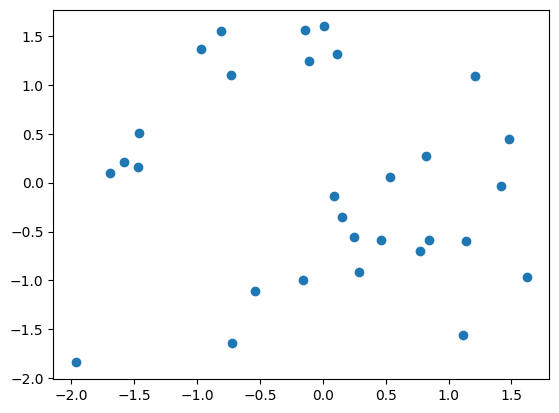

In [ ]:
x = [coord[0] for coord in normed_graphs[ith_run]]
y = [coord[1] for coord in normed_graphs[ith_run]]
plt.scatter(x,y)
plt.show()

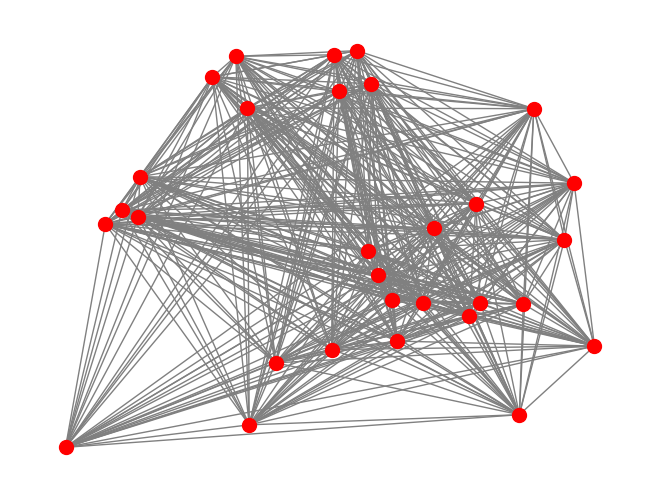

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
positions = {i: (x[i], y[i]) for i in range(len(x))}
G.add_nodes_from(positions.keys())
edges = [(i, j) for i in range(len(x)) for j in range(i + 1, len(x))]
G.add_edges_from(edges)
#plt.figure(figsize=(4, 4))
nx.draw(G, pos=positions, node_color='red', node_size=100, edge_color='gray')
plt.show()

In [ ]:
for index in normed_graphs:
  normed_graphs[index] = np.array(normed_graphs[index]).flatten()

In [ ]:
len(normed_graphs[0]), normed_graphs[0]

(60,
 array([-0.53957575,  0.4398966 , -0.57636841,  0.28891542,  0.83410605,
        -0.99843048, -0.09415066,  3.08863531, -0.81233028, -0.96717734,
         0.05695089, -0.58168756,  4.00559883,  0.13658722, -0.745388  ,
        -0.19878064, -0.61743232,  2.51037189, -0.37459028,  0.04418079,
         1.20768504, -0.04250437, -0.54963843, -0.2618439 ,  1.33741181,
        -0.86102752, -0.47981997, -1.00950338, -0.64860562, -0.37099122,
         0.80669114, -0.85987892, -0.82568323, -0.3869439 , -0.3475996 ,
         0.09549198, -0.7184079 ,  0.11789276, -0.23164877,  0.38481866,
        -0.80177963, -0.53811608, -0.47814122,  2.09883731,  1.5810967 ,
        -0.36581131,  0.07663415, -0.04037545, -0.41677442, -0.76171185,
         0.60644975,  0.22005312, -0.25071462, -0.31015826, -0.18220782,
         1.05483859, -0.0163723 , -0.94961733, -0.80539512, -0.97596014]))

In [ ]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

#### Dataloader

In [ ]:
instance_dict = {'train': [], 'val': []}
dataset_sizes = {'train': 0, 'val': 0}

for i in range(len(normed_graphs)):
  if np.random.rand() < 0.8:
    instance_dict['train'].append(normed_graphs[i])
    dataset_sizes['train'] += 1
  else:
    instance_dict['val'].append(normed_graphs[i])
    dataset_sizes['val'] += 1

class TSPDataset(Dataset):
    def __init__(self, instances):
        self.instances = instances

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        coordinates = torch.tensor(self.instances[idx], dtype=torch.float32)
        return coordinates

datasets = {x: TSPDataset(instance_dict[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(datasets[x], batch_size=16, shuffle=True) for x in ['train', 'val']}

for instance_data in dataloaders['train']:
    print(instance_data.shape)
    break

torch.Size([16, 60])


### The Autoencoder

In [ ]:
class Autoencoder_TSP(nn.Module):
    def __init__(self, bottleneck):
        super(Autoencoder_TSP, self).__init__()

        self.sig = nn.Sigmoid()

        self.enc1 = nn.Linear(60, 45)
        self.enc2 = nn.Linear(45, bottleneck)
        self.dec1 = nn.Linear(bottleneck, 45)
        self.dec2 = nn.Linear(45, 60)

    def forward(self, x):

        x = self.enc1(x)
        x = self.sig(x)
        x = self.enc2(x)
        x = self.sig(x)
        x = self.dec1(x)
        x = self.sig(x)
        x = self.dec2(x)
        x = self.sig(x)
        x = 2*x - 1             # to re-adjust x value to the interval [-1,1]

        return x

### The Training

In [ ]:
import time
from copy import deepcopy
import matplotlib.pyplot as plt

In [ ]:
def train(model, criterion, optimizer, scheduler, lambda1 = 0, num_epochs = 25):

  since = time.time()

  best_model_wts = deepcopy(model.state_dict())
  best_loss = 1000

  _loss = {'train': [], 'val': []}

  for epoch in range(num_epochs):
    if (epoch+1) % 10 == 0 or epoch == 0:
      print(f'\nEpoch {epoch+1}/{num_epochs}')
      print('-' * 10)

    # each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()     # set model to training mode
      else:
        model.eval()      # set model to validation mode

      running_loss = 0

      # iterate over data
      for inputs in dataloaders[phase]:
        inputs = inputs.to(device)
        # .to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          output = model(inputs)
          loss = criterion(output, inputs)

          # Regularization if necessary

          # backward + optimize only if training
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss/dataset_sizes[phase]

      if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'{phase} Loss: {epoch_loss:.4f}')

      _loss[phase].append(epoch_loss)

      if phase == 'val' and epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val loss: {best_loss:.4f}')

  # Load best model weights and return
  model.load_state_dict(best_model_wts)
  return model, _loss

In [ ]:
# using GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
lambda1 = [1e-6]#, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lr = [0.5]#, 0.003, 0.005, 0.005, 0.008, 0.01]
Loss = {'train': [], 'val': []}
bottleneck = 30

for i in range(len(lambda1)):

  print(f"Training with lambda2 = {lambda1[i]}")
  net = Autoencoder_TSP(bottleneck)
  net.to(device)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(net.parameters(), lr = lr[i], momentum = 0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)
  num_epochs = 100

  net, _loss = train(net, criterion, optimizer, scheduler, lambda1[i], num_epochs)

  for phase in ['train', 'val']:
    Loss[phase].append(_loss[phase])

  print('='*20)

Training with lambda2 = 1e-06

Epoch 1/100
----------
train Loss: 0.0656
val Loss: 0.0882

Epoch 10/100
----------
train Loss: 0.0634
val Loss: 0.0887

Epoch 20/100
----------
train Loss: 0.0633
val Loss: 0.0892

Epoch 30/100
----------
train Loss: 0.0633
val Loss: 0.0891

Epoch 40/100
----------
train Loss: 0.0632
val Loss: 0.0886

Epoch 50/100
----------
train Loss: 0.0632
val Loss: 0.0887

Epoch 60/100
----------
train Loss: 0.0632
val Loss: 0.0885

Epoch 70/100
----------
train Loss: 0.0632
val Loss: 0.0898

Epoch 80/100
----------
train Loss: 0.0632
val Loss: 0.0884

Epoch 90/100
----------
train Loss: 0.0632
val Loss: 0.0885

Epoch 100/100
----------
train Loss: 0.0632
val Loss: 0.0893
Training completed in 0m 1s
Best val loss: 0.0877


# EDA

`data tensor = A[graph_index][data for each relax param]`

`data = [A,pf,estd,eavg,emin]`

In [ ]:
ith_graph = np.random.randint(100)
values = runs[ith_graph]
As = [value[0] for value in values]
pfs = [value[1] for value in values]
estds = [value[2] for value in values]
eavs = [value[3] for value in values]
emins = [value[4] for value in values]
values[1]

[505.0, 0.0234375, 8300.78913463635, 572.4673977370852, 6837.371914517396]

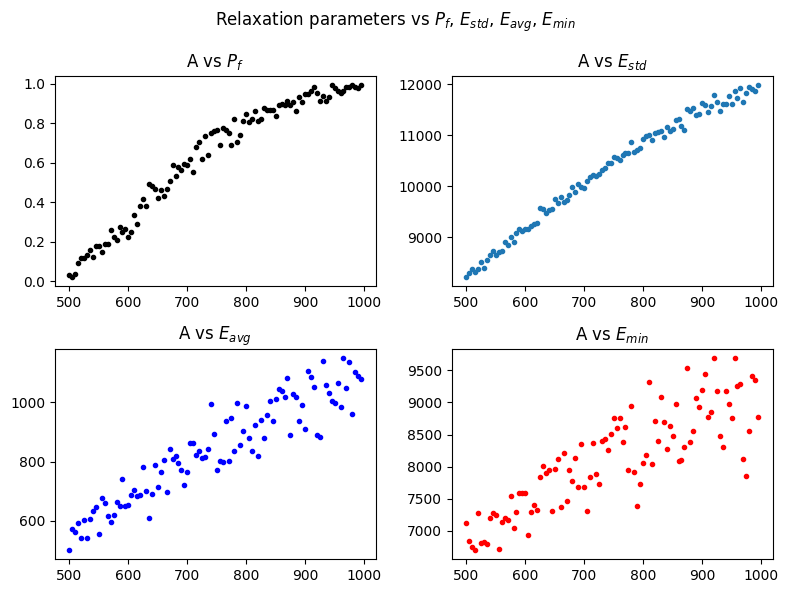

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
fig.suptitle('Relaxation parameters vs $P_f$, $E_{std}$, $E_{avg}$, $E_{min}$')

axs[0, 0].set_title("A vs $P_f$")
axs[0, 0].scatter(As, pfs, marker = ".", c = 'k')

axs[0, 1].set_title("A vs $E_{std}$")
axs[0, 1].scatter(As, estds, marker = ".")

axs[1, 0].set_title("A vs $E_{avg}$")
axs[1, 0].scatter(As, eavs, marker = ".", c ='b')

axs[1, 1].set_title("A vs $E_{min}$")
axs[1, 1].scatter(As, emins, marker = ".", c='r')

fig.tight_layout()
fig.savefig('datavis_qross.png')